## Viscolelastic Materials Example

First we Choose the model and other parameters for our data, and save this data for reference later:

In [1]:
import numpy as np
import sympy as sp
import sys

sys.path.append('../')
import data.Generation.VE_DataGen_Functions as vedg

In [14]:
Input_Type = 'Strain'
E = [1,1,1]
Eta = [1.25,2.5]
t = sp.symbols('t', real=True)
Input_Function = sp.sin(t)
Input_Description = 'Periodic'
Int_Type = 'Analytical'

Tuple_of_Expressions = vedg.Stress_Strain_Master_Int(Input_Type, E, Eta, Input_Function, Int_Type, t)
print(Tuple_of_Expressions)

1 + exp(-0.8*t) + exp(-0.4*t)
cos(t)
(exp(-0.8*t + 0.8*x) + exp(-0.4*t + 0.4*x) + 1)*cos(x)
0
1.0*exp(1.11022302462516e-16*t)*sin(t) + 0.4*exp(1.4432899320127e-15*t)*cos(t) + 0.48780487804878*exp(2.88657986402541e-15*t)*cos(t) + 1.46364220568022e-16*exp(8.65973959207622e-15*t)*sin(t) + 1.17091376454417e-16*exp(8.65973959207622e-15*t)*cos(t) + 2.0*sin(t) - 0.48780487804878*exp(-0.799999999999997*t) - 1.17091376454417e-16*exp(-0.799999999999991*t) - 0.4*exp(-0.399999999999999*t) - 0.390243902439024*exp(-6.66133814775094e-16*t)*sin(t)
1.0*exp(1.11022302462516e-16*t)*sin(t) + 0.4*exp(1.4432899320127e-15*t)*cos(t) + 0.48780487804878*exp(2.88657986402541e-15*t)*cos(t) + 1.46364220568022e-16*exp(8.65973959207622e-15*t)*sin(t) + 1.17091376454417e-16*exp(8.65973959207622e-15*t)*cos(t) + 2.0*sin(t) - 0.48780487804878*exp(-0.799999999999997*t) - 1.17091376454417e-16*exp(-0.799999999999991*t) - 0.4*exp(-0.399999999999999*t) - 0.390243902439024*exp(-6.66133814775094e-16*t)*sin(t)
1.0*exp(1.11022302

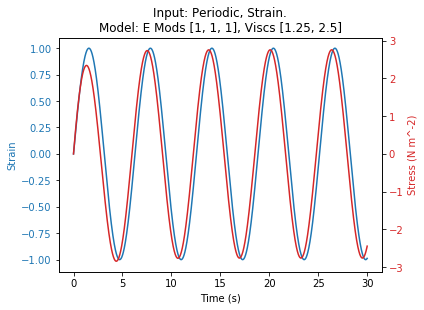

In [15]:
time = np.linspace(0, 30, 5000)

title = ('Input: ' + Input_Description + ', ' + Input_Type + 
         '.\nModel: E Mods ' + str(E) + ', Viscs ' + str(Eta))

Strain_Array, Stress_Array = vedg.Eval_Graph_Strain_Stress(title, time, Input_Function, Tuple_of_Expressions, Input_Type, Int_Type, t)

In [13]:
vedg.save_stress_strain(time, Strain_Array, Stress_Array, '../data/StressStrain', Input_Type, Input_Description, E, Eta)

We mostly use DeepMoD using default settings as we would for any other problems. the configuratiosn specific to this application come from knowledge we already have, namely:

- We are going to use a customised $\Theta$ that only ever computes the derivatives of stress and strain, never the squares, as we are looking solve a system where these are the only terms present. We are looking at a hybrid problem here where we aren't completely blindly exploring the system. We assume the data is stress/strain data and we assume our models for these materials are accurate so as to produce an accurate format for the equations describing their dynamic behaviour.

- For this, we need to use a library function of a new design.

- In this library function, we will ask PyTorch to compute derivatives for the output variable up to a couple of orders of differentiation beyond expectations, just to demonstrate teh DeepmoD both, finds the correct coefficients, but also removes terms that should not be present.

- the library function will also contain the assumption that all coefficients on the input function are negative. this way, teh coefficients that DeepMoD shoudl find will all be positive, as all viscosties and elastic moduli are postive, so all sums and products of them are also, and this si what makes up the coefficient.

- This will allow us to further tinker and ask the random initial values of teh coefficients to all be positive, getting round an issue with DeepMod getting stuck in local minima

- The derivatives of teh input function can be calculated without the neural network, as teh functional form of this is know. These results are still built into the loss though, as part of the equation-regression term.

- Additionalyl, the lambda paramter will be made small. in essence, we are not looking for a very sparse vector, so L1 regullarisation actually hinders the convergence process.

- Additionally, the LHS of the equation is fixed to the time derivative of the input with coeff 1

> Is it the time derivative of the input, or always strain!!!!!!

Once DeepMoD has its coefficnets, the job is not done as the coefficients need to be traced back into E_Mods and Viscs. i am not yet sure how to do this but

- there will be two stages. the first is developing teh expressions for coeff 1 is this combination, coeff 2 is that one etc, and then teh second stage is using these simultaneous expressions to instead right each paramter in terms of teh coeffs.

- The first part is not trivial as the parameters that go into forming the coeffs will be different depending on how many parameters are genuinely present in the model. The number of derivatives that deepmod finds can be used to determine which set of equations are going to be used.

- Either these equations can be hard coded or

- A pattern can be identified so that once the number of paramters is known, a loop can be run to generate teh expressions or

- The root equation with sum could be looped and written in sympy, and the rearranged and sympy could be asked to find the expressions for coeffs of each term. the function `Differential` rather than `.diff` will be useful here to maintain the unsolved derivatives.

- The coeff on the RHS of the equation being fixed to 1 fixes all the other coeffs, so there is no ambiguity here.

For the second part, using the coeffs to calculate each model parameter

- I am hoping i can just use some function called solve or something in sympy to get the expressions for each aparamter in term so the coeffs, once the part 1 above is done. Indeed, this is possible on mathematica as demonstrated by the screenshot Remy sent by email.

- Alternatively, they could be hard coded in if worked them out by hand......

Extra idea: The order of derivative should be teh same in both stress and strain. This is not a wild assumption. Perhaps teh loss can be further modified so as to penilise a situation where higher derivatives are being allowed in the 1st half of coeffs vs the other.